In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

In [2]:
import sys
sys.path.append("/g/g92/dskoda/prj/dskrc/python/inits")

from plotting import *
plt.rcParams['figure.dpi'] = 150
plt.style.use("paper")

In [3]:
hpr = pd.read_csv("02_data/nequip_hyperparams.csv", index_col=0)
lcv = pd.read_csv("02_data/nequip_learning.csv", index_col=0)
lls = pd.read_csv("02_data/nequip_losslands.csv", index_col=0)
sdf = pd.read_csv("02_data/nequip_entropy.csv", index_col=0)
exp = pd.read_csv("02_data/nequip_explosion.csv", index_col=0)
ext = pd.read_csv("02_data/nequip_extrapolation_errors.csv", index_col=0)

In [4]:
LABELS = {
    "baseline": "no rescaling",
    "non_trainable_bessel": "no Bessel",
    "rescaling": "rescaling + bessel",
}

FIGS_DIR = "03_figs"

In [5]:
MODELS = {
    "BIG": ["baseline", "non_trainable_bessel", "rescaling"],
    "2-OPT":  ["2-layer, baseline", "2-layer, AMSGrad-only", "2-layer, EMA-only"],
    "5-OPT":  ["5-layer, baseline", "5-layer, AMSGrad-only", "5-layer, EMA-only"],
    "LAYERS": ["2-layer", "3-layer", "4-layer", "5-layer"],
}

MODELS_ORDER = MODELS["BIG"] + MODELS["2-OPT"] + MODELS["5-OPT"] + MODELS["LAYERS"]

In [6]:
CMAPS = {
    "BIG": cm.Reds_r,
    "2-OPT": cm.Blues_r,
    "5-OPT": cm.Greens_r,
    "LAYERS": cm.Purples_r,
}

In [7]:
_colors = {}
for mset, cases in MODELS.items():
    norm = plt.Normalize(0, len(cases))
    for i, name in enumerate(cases):
        _colors[name] = CMAPS[mset](norm(i))
    
labels = pd.Series(_colors)

In [8]:
def sort_df_by_category(df, key, sorter):
    df = df.copy()
    df["cat"] = df[key].astype("category")
    df["cat"] = df["cat"].cat.set_categories(sorter)
    df = df.sort_values(["cat"]).drop("cat", axis=1)
    
    return df

## Explosion times

webf NOT subset; don't know how to subset; dropped


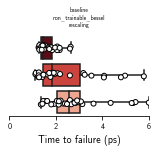

webf NOT subset; don't know how to subset; dropped


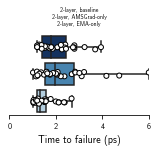

webf NOT subset; don't know how to subset; dropped


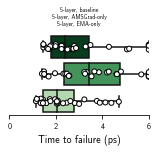

webf NOT subset; don't know how to subset; dropped


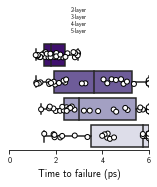

In [9]:
for name, grp in MODELS.items():
    _df = exp.loc[exp.model.isin(grp)].sort_values("model")
    _df["explosion"] = _df["explosion"] / 1000
    _df = sort_df_by_category(_df, "model", grp)
    
    norm = plt.Normalize(0, len(grp))
    palette = [CMAPS[name](norm(i)) for i in range(len(grp))]
    
    rows = len(grp) / 4
    fig, ax = plt.subplots(figsize=(2.5, 2 * rows))

    sns.boxplot(
        data=_df,
        x="explosion",
        y="model",
        ax=ax,     
        palette=palette,
        whis=(0, 100),
    )

    sns.stripplot(
        data=_df,
        x="explosion",
        y="model",
#         alpha=0.75,
        ax=ax,
        color="w",
        size=5,
        edgecolor="k",
        linewidth=1
    )

    ax.set_xlabel("Time to failure (ps)")
    ax.set_ylabel("")
    ax.spines["left"].set_visible(False)
    ax.set_xlim(0, 6)
    
    _labels = "\n".join(grp)
    ax.set_title(_labels, fontsize="xx-small")
    ax.set_yticks([])
    
    fig.savefig(f"{FIGS_DIR}/nequip_explosion_{name}.pdf", bbox_inches="tight", transparent=True)
    plt.show()

webf NOT subset; don't know how to subset; dropped


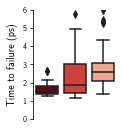

webf NOT subset; don't know how to subset; dropped


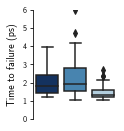

webf NOT subset; don't know how to subset; dropped


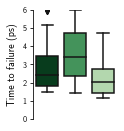

webf NOT subset; don't know how to subset; dropped


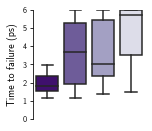

In [22]:
for name, grp in MODELS.items():
    _df = exp.loc[exp.model.isin(grp)].sort_values("model")
    _df["explosion"] = _df["explosion"] / 1000
    _df = sort_df_by_category(_df, "model", grp)
    
    norm = plt.Normalize(0, len(grp))
    palette = [CMAPS[name](norm(i)) for i in range(len(grp))]
    
    rows = len(grp) / 4
    fig, ax = plt.subplots(figsize=(2 * rows, 2))

    sns.boxplot(
        data=_df,
        x="model",
        y="explosion",
        ax=ax,     
        palette=palette,
#         whis=(0, 100),
    )

#     sns.stripplot(
#         data=_df,
#         x="explosion",
#         y="model",
# #         alpha=0.75,
#         ax=ax,
#         color="w",
#         size=5,
#         edgecolor="k",
#         linewidth=1
#     )

    ax.set_ylabel("Time to failure (ps)")
    ax.set_xlabel("")
    ax.spines["bottom"].set_visible(False)
    ax.set_ylim(0, 6)
    
    _labels = "\n".join(grp)
#     ax.set_title(_labels, fontsize="xx-small")
    ax.set_xticks([])
    
    fig.savefig(f"{FIGS_DIR}/nequip_explosion_vert_{name}.pdf", bbox_inches="tight", transparent=True)
    plt.show()

## Loss Landscapes

webf NOT subset; don't know how to subset; dropped


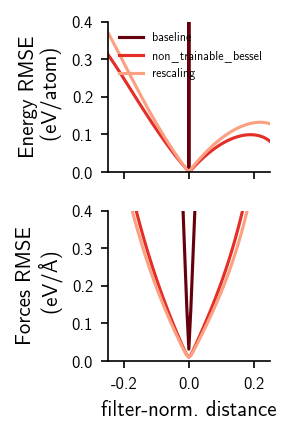

webf NOT subset; don't know how to subset; dropped


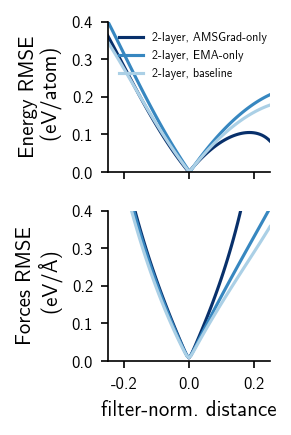

webf NOT subset; don't know how to subset; dropped


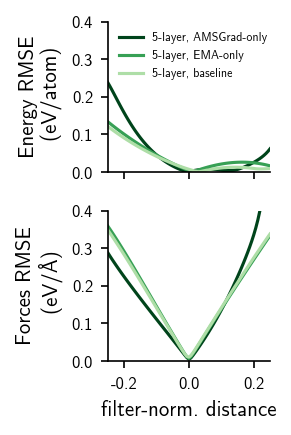

webf NOT subset; don't know how to subset; dropped


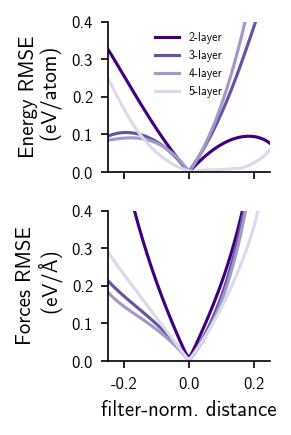

In [30]:
for name, grp in MODELS.items():
    _df = lls.loc[lls.model.isin(grp)].sort_values("model")
    _df = sort_df_by_category(_df, "model", grp)
    
    norm = plt.Normalize(0, len(grp))
    colors = [CMAPS[name](norm(i)) for i in range(len(grp))]
    
    fig, ax_fig = plt.subplots(2, 1, figsize=(2, 3), sharex=True)
    
    for color, (model, _subdf) in zip(colors, _df.groupby("model")):
        _subdf = _subdf.sort_values("x")
        
        for ax, qty in zip(ax_fig, ["e", "f"]):
            ax.plot(
                _subdf["x"],
                _subdf[qty],
                color=color,
                label=model,
            )
            ax.set_ylim(0.0, 0.4)
            ax.set_xlim(-0.25, 0.25)
    
    ax.set_xlabel("filter-norm. distance")
    ax_fig[0].set_ylabel("Energy RMSE\n (eV/atom)")
    ax_fig[1].set_ylabel("Forces RMSE\n (eV/Å)")
    
    ax_fig[0].legend(frameon=False, fontsize="xx-small")
    
    fig.tight_layout()
    
    fig.savefig(f"{FIGS_DIR}/nequip_lls_{name}.pdf", bbox_inches="tight", transparent=True)
    plt.show()

## Trends in entropy

webf NOT subset; don't know how to subset; dropped


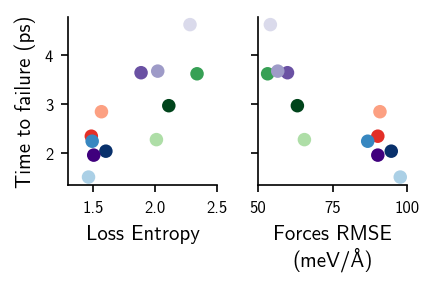

In [74]:
fig, ax_fig = plt.subplots(1, 2, figsize=(3, 2), sharey=True)

for name, grp in MODELS.items():
    _df = sdf.loc[grp]
    
    colors = labels.loc[_df.index]
    
    _y = _df["explosion_mean"] / 1000
    ax = ax_fig[0]
    ax.scatter(
        _df["S"],
        _y,
        c=colors,
        s=30,
    )
    ax.set_xlabel("Loss Entropy")
    ax.set_ylabel("Time to failure (ps)")
    ax.set_xlim(1.3, 2.5)
    
    ax = ax_fig[1]
    ax.scatter(
        _df["f"] * 1000,
        _y,
        c=colors,
        s=30,
    )
    ax.set_xlabel("Forces RMSE\n(meV/Å)")
    ax.set_xlim(50, 100)
    
fig.tight_layout()
fig.savefig(f"{FIGS_DIR}/nequip_entropy_overview.pdf", bbox_inches="tight", transparent=True)
plt.show()

webf NOT subset; don't know how to subset; dropped


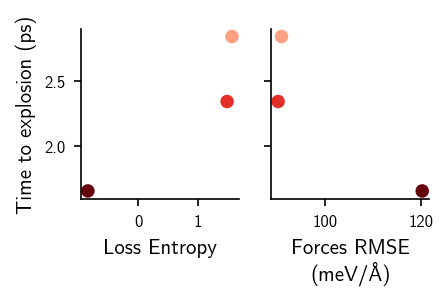

webf NOT subset; don't know how to subset; dropped


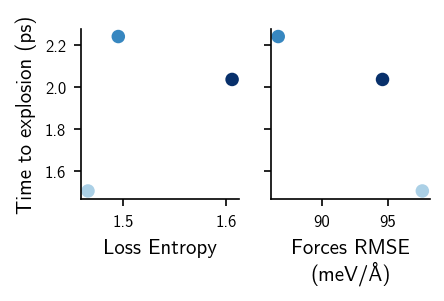

webf NOT subset; don't know how to subset; dropped


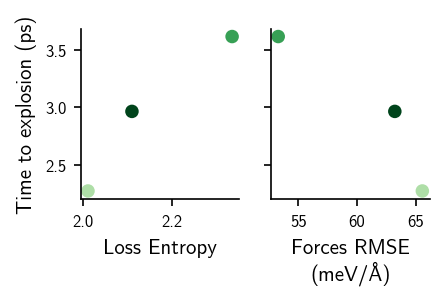

webf NOT subset; don't know how to subset; dropped


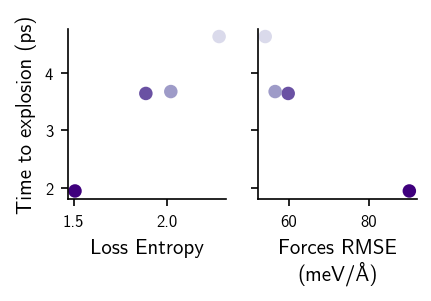

In [76]:
for name, grp in MODELS.items():
    _df = sdf.loc[grp]
    colors = labels.loc[_df.index]
    
    fig, ax_fig = plt.subplots(1, 2, figsize=(3, 1.5), sharey=True)
        
    ax = ax_fig[0]
    _y = _df["explosion_mean"] / 1000
    ax.scatter(
        _df["S"],
        _y,
        c=colors,
        s=30,
    )
    ax.set_xlabel("Loss Entropy")
    ax.set_ylabel("Time to explosion (ps)")
#     ax.set_xlim(1.3, 2.5)
    
    ax = ax_fig[1]
    ax.scatter(
        _df["f"] * 1000,
        _y,
        c=colors,
        s=30,
    )
    ax.set_xlabel("Forces RMSE\n(meV/Å)")    
    
#     fig.tight_layout()
    fig.savefig(f"{FIGS_DIR}/nequip_entropy_{name}.pdf", bbox_inches="tight", transparent=True)
    plt.show()

webf NOT subset; don't know how to subset; dropped


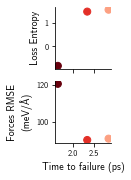

webf NOT subset; don't know how to subset; dropped


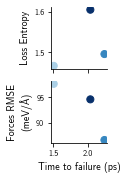

webf NOT subset; don't know how to subset; dropped


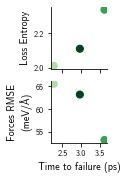

webf NOT subset; don't know how to subset; dropped


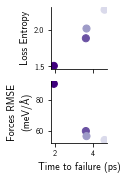

In [29]:
for name, grp in MODELS.items():
    _df = sdf.loc[grp]
    colors = labels.loc[_df.index]
    
    fig, ax_fig = plt.subplots(2, 1, figsize=(1, 2.5), sharex=True)
        
    ax = ax_fig[0]
    _x = _df["explosion_mean"] / 1000
    ax.scatter(
        _x,
        _df["S"],
        c=colors,
        s=50,
    )
    ax.set_ylabel("Loss Entropy")
#     ax.set_xlim(1.3, 2.5)
    
    ax = ax_fig[1]
    ax.scatter(
        _x,
        _df["f"] * 1000,
        c=colors,
        s=50,
    )
    ax.set_ylabel("Forces RMSE\n(meV/Å)") 
    ax.set_xlabel("Time to failure (ps)")
    
#     fig.tight_layout()
    fig.savefig(f"{FIGS_DIR}/nequip_entropy_vert_{name}.pdf", bbox_inches="tight", transparent=True)
    plt.show()

## Slopes

In [43]:
slopes = lcv.pivot(index='model', columns="n", values="f")
slopes = slopes.drop(5, axis=1)
logslopes = np.log(slopes)

In [44]:
_slopes = {}

logn = np.log(logslopes.columns)

for model, row in logslopes.iterrows():    
    linregress = stats.linregress(logn, row.values)
    _slopes[model] = linregress.slope

slope_df = pd.DataFrame(_slopes.values(), index=_slopes.keys(), columns=["slopes"])

In [45]:
sdf2 = pd.concat([sdf, slope_df], axis=1).dropna()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
webf NOT subset; don't know how to subset; dropped


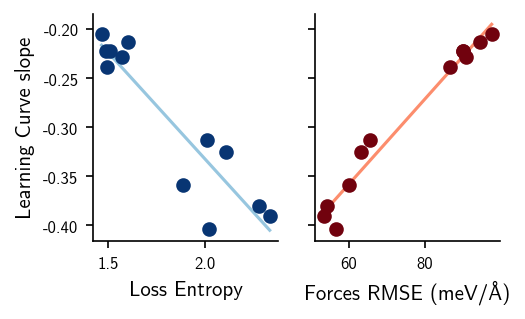

In [72]:
fig, ax_fig = plt.subplots(1, 2, figsize=(3.5, 2), sharey=True)

_df = sdf2.loc[sdf2["S"] > 0]

ax = ax_fig[0]
_x = _df["S"]
_y = _df["slopes"]

ax.scatter(_x, _y, c=cm.Blues(250))

ax.set_ylabel("Learning Curve slope")
ax.set_xlabel("Loss Entropy")

reg = stats.linregress(_x, _y)
newx = np.linspace(_x.min(), _x.max(), 3)
newy = reg.slope * newx + reg.intercept

ax.plot(newx, newy, zorder=-1, color=cm.Blues(100))


ax = ax_fig[1]
_x = _df["f"] * 1e3
_y = _df["slopes"]

ax.scatter(_x, _y, c=cm.Reds(250))

# ax.set_ylabel("Learning Curve slope")
ax.set_xlabel("Forces RMSE (meV/Å)")

reg = stats.linregress(_x, _y)
newx = np.linspace(_x.min(), _x.max(), 3)
newy = reg.slope * newx + reg.intercept

ax.plot(newx, newy, zorder=-1, color=cm.Reds(100))

fig.savefig(f"{FIGS_DIR}/nequip_slopes.pdf", bbox_inches="tight", transparent=True)
plt.show()

## Showing that errors at 300 K do not help

In [12]:
ext2 = pd.concat([
    ext.pivot(columns="nsamples", values="test_300K_forces", index="label"),
    sdf["f"],
], axis=1).drop(5, axis=1).dropna()

In [13]:
ext2

,25,125,250,500,f
2-layer,0.089785,0.043670,0.033245,0.025208,0.090100
"2-layer, AMSGrad-only",0.091679,0.045015,0.033647,0.024967,0.086723
"2-layer, EMA-only",0.093170,0.045585,0.033979,0.025430,0.097598
"2-layer, baseline",0.092056,0.045912,0.034019,0.025712,0.094594
3-layer,0.093161,0.033137,0.022376,0.015270,0.059912
4-layer,0.095086,0.031329,0.019682,0.012463,0.056658
5-layer,0.087681,0.028654,0.018954,0.013121,0.054190
"5-layer, AMSGrad-only",0.087818,0.028643,0.019380,0.014442,0.053277
"5-layer, EMA-only",0.088767,0.029145,0.020113,0.014544,0.065567
"5-layer, baseline",0.088749,0.030037,0.020363,0.016077,0.063221


webf NOT subset; don't know how to subset; dropped


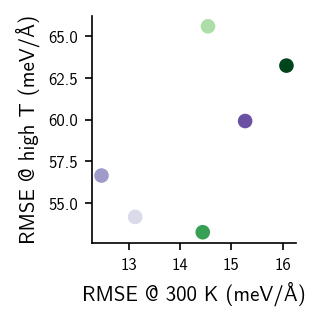

In [71]:
_df = ext2.loc[ext2[500] < 0.02]
_x = _df[500] * 1000
_y = _df["f"] * 1000
_c = labels.loc[_df.index].values

fig, ax = plt.subplots(figsize=(1.75, 2))

ax.scatter(_x, _y, c=_c)
ax.set_xlabel("RMSE @ 300 K (meV/Å)")
ax.set_ylabel("RMSE @ high T (meV/Å)")

fig.savefig(f"{FIGS_DIR}/nequip_RMSE_temperatures.pdf", bbox_inches="tight", transparent=True)

plt.show()

webf NOT subset; don't know how to subset; dropped


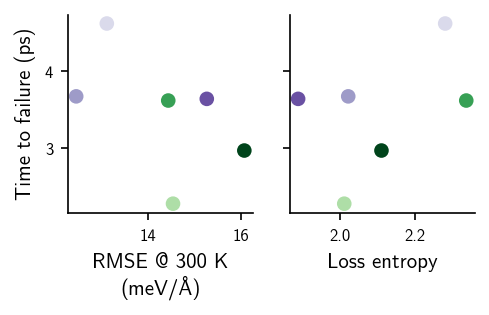

In [70]:
fig, ax_fig = plt.subplots(1, 2, figsize=(3.5, 1.75), sharey=True)

_df = ext2.loc[ext2[500] < 0.02]

ax = ax_fig[0]
_x = _df[500] * 1000
_y = sdf.loc[_x.index, "explosion_mean"] / 1000
_c = labels.loc[_x.index].values

ax.scatter(_x, _y, c=_c)
ax.set_xlabel("RMSE @ 300 K\n(meV/Å)")
ax.set_ylabel("Time to failure (ps)")

ax = ax_fig[1]
_x = sdf.loc[_df.index, "S"]
_y = sdf.loc[_x.index, "explosion_mean"] / 1000
_c = labels.loc[_x.index].values

ax.scatter(_x, _y, c=_c)
ax.set_xlabel("Loss entropy")
# ax.set_ylabel("Time to failure (ps)")

fig.savefig(f"{FIGS_DIR}/nequip_lowRMSE_trends.pdf", bbox_inches="tight", transparent=True)
plt.show()